# 7.3 Developing and Evaluating Chunkers

In [1]:
# A conversion function chunk.conllstr2tree() builds a tree representation from 1 of these multi-line strings 
#containing IOB notation
import nltk

In [2]:
import nltk
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''
text

'\nhe PRP B-NP\naccepted VBD B-VP\nthe DT B-NP\nposition NN I-NP\nof IN B-PP\nvice NN B-NP\nchairman NN I-NP\nof IN B-PP\nCarlyle NNP B-NP\nGroup NNP I-NP\n, , O\na DT B-NP\nmerchant NN I-NP\nbanking NN I-NP\nconcern NN I-NP\n. . O\n'

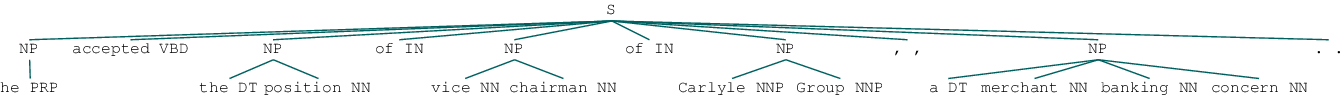

In [3]:
nltk.chunk.conllstr2tree(text, chunk_types=["NP"])

In [4]:
from nltk.corpus import conll2000

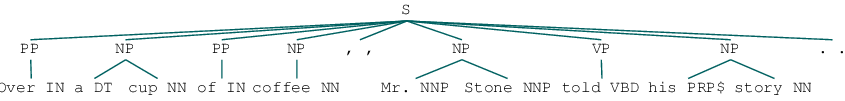

In [5]:
#Seeing all chunk types (NP, VP, PP) NP - Noun Phrase; VP - Verb Phrase, PP - Prepositional Phrase
conll2000.chunked_sents('train.txt')[99]

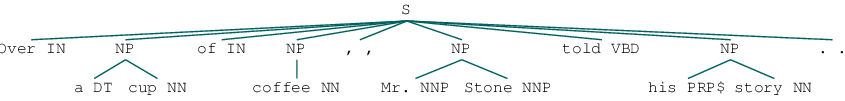

In [6]:
#Seeing only NP chunk types (the PP and VP) chunk types disappear
conll2000.chunked_sents('train.txt', chunk_types=["NP"])[99]

In [7]:
#Now that we can access a chunked corpus, we can now evaluate chunkers
from nltk.corpus import conll2000
#???
cp = nltk.RegexpParser("")
#Get all the chunked sentences of the test document in the corpus. Filter only NP chunk types
test_sents = conll2000.chunked_sents('test.txt', chunk_types=["NP"])
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


**Observations**
- 43% of the words are tagged as `O`, not an NP chunk.
- The chunker did not find any chunks. Hence the precision, recall and F-measure are all 0

In [20]:
#Let's try a naive expression chunker looking for tags that begin with letters that are characteristic of NP tags:
#CD, DT, JJ
grammar = r"NP:{<[CDJNP].*>+}"
cp2 = nltk.RegexpParser(grammar)
print(cp2.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


In [9]:
#We define the UnigramChunker class, which uses a unigram
#tagger to label sentences with chunk tags.
class UnigramChunker(nltk.ChunkParserI):
    #expects a list of training sentences as the parameter
    #in the form of chunk trees
    #then converts the training data to a form that's suitable for training the tagger
    def __init__(self, train_sents):
        #use chunk.tree2conlltags to map each chunk tree to a list of [word,tag,chunk] triples
        train_data = [[(t, c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                     for sent in train_sents]
        #use that converted training data to train a unigram tagger
        self.tagger = nltk.UnigramTagger(train_data)
    
    #expects a tagged sentence as its input, extracts part-of-speech
    #tags from the sentence. then tags the part of speech tag
    #with IOB chunk tags, using self.tagger in the constructor
    #extracts the chunk tags, and converts them with the original
    #sentence
    #and uses conlltags2tree to convert back to a chunk tree
    def parse(self, sentence):

        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                    in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [10]:
#Now that we have a UnigramChunker, we can train it using CoNLL-200 Chunking corpus
test_sents = conll2000.chunked_sents('test.txt', chunk_types=["NP"])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=["NP"])
unigram_chunker = UnigramChunker(train_sents)
print (unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


In [11]:
#Let's take a look at what it's learnt, by using its unigram tagger to
#assign a tag to each of the POS tags that appear in the corpus
pos_tags = sorted(set(pos for sent in train_sents for (word, pos) in sent.leaves()))
unigram_chunker.tagger.tag(pos_tags)

[('#', 'B-NP'),
 ('$', 'B-NP'),
 ("''", 'O'),
 ('(', 'O'),
 (')', 'O'),
 (',', 'O'),
 ('.', 'O'),
 (':', 'O'),
 ('CC', 'O'),
 ('CD', 'I-NP'),
 ('DT', 'B-NP'),
 ('EX', 'B-NP'),
 ('FW', 'I-NP'),
 ('IN', 'O'),
 ('JJ', 'I-NP'),
 ('JJR', 'B-NP'),
 ('JJS', 'I-NP'),
 ('MD', 'O'),
 ('NN', 'I-NP'),
 ('NNP', 'I-NP'),
 ('NNPS', 'I-NP'),
 ('NNS', 'I-NP'),
 ('PDT', 'B-NP'),
 ('POS', 'B-NP'),
 ('PRP', 'B-NP'),
 ('PRP$', 'B-NP'),
 ('RB', 'O'),
 ('RBR', 'O'),
 ('RBS', 'B-NP'),
 ('RP', 'O'),
 ('SYM', 'O'),
 ('TO', 'O'),
 ('UH', 'O'),
 ('VB', 'O'),
 ('VBD', 'O'),
 ('VBG', 'O'),
 ('VBN', 'O'),
 ('VBP', 'O'),
 ('VBZ', 'O'),
 ('WDT', 'B-NP'),
 ('WP', 'B-NP'),
 ('WP$', 'B-NP'),
 ('WRB', 'O'),
 ('``', 'O')]

**Observations**

- Punctuation marks appear outside of NP chunks, with the exception of `#` and `$` which represent currency
- Determiners (`DT`) and possessives (`PRP$` and `WP$`) occur at the beginning of NP chunks
- Noun Types (`NN`, `NNP`, `NNPS`, `NNS`) occur mostly inside of NP chunks

In [12]:
pos_tags = sorted(set(pos for sent in train_sents for (word, pos) in sent.leaves()))

In [13]:
#We define the UnigramChunker class, which uses a unigram
#tagger to label sentences with chunk tags.
class BigramChunker(nltk.ChunkParserI):
    #expects a list of training sentences as the parameter
    #in the form of chunk trees
    #then converts the training data to a form that's suitable for training the tagger
    def __init__(self, train_sents):
        #use chunk.tree2conlltags to map each chunk tree to a list of [word,tag,chunk] triples
        train_data = [[(t, c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                     for sent in train_sents]
        #use that converted training data to train a unigram tagger
        self.tagger = nltk.BigramTagger(train_data)
    
    #expects a tagged sentence as its input, extracts part-of-speech
    #tags from the sentence. then tags the part of speech tag
    #with IOB chunk tags, using self.tagger in the constructor
    #extracts the chunk tags, and converts them with the original
    #sentence
    #and uses conlltags2tree to convert back to a chunk tree
    def parse(self, sentence):

        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag)
                    in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [14]:
#Now that we have a UnigramChunker, we can train it using CoNLL-200 Chunking corpus
test_sents = conll2000.chunked_sents('test.txt', chunk_types=["NP"])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=["NP"])
bigram_chunker = BigramChunker(train_sents)
print (bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


In [15]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):
    def __init__(self, train_sets):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train(
        train_set, algorithm='megam', trace=0)
        
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)
    



In [28]:
class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) \
                         for (w,t,c) in nltk.chunk.tree2conlltags(sent)] \
                         for sent in train_sents] 
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)
    
    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)
    
#Feature Extraction
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos":pos}

chunker = ConsecutiveNPChunker(train_sents)


ValueError: need more than 1 value to unpack

In [22]:
[[((w,t),c) for (w,t,c) in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]

[[(('Confidence', 'NN'), 'B-NP'),
  (('in', 'IN'), 'O'),
  (('the', 'DT'), 'B-NP'),
  (('pound', 'NN'), 'I-NP'),
  (('is', 'VBZ'), 'O'),
  (('widely', 'RB'), 'O'),
  (('expected', 'VBN'), 'O'),
  (('to', 'TO'), 'O'),
  (('take', 'VB'), 'O'),
  (('another', 'DT'), 'B-NP'),
  (('sharp', 'JJ'), 'I-NP'),
  (('dive', 'NN'), 'I-NP'),
  (('if', 'IN'), 'O'),
  (('trade', 'NN'), 'B-NP'),
  (('figures', 'NNS'), 'I-NP'),
  (('for', 'IN'), 'O'),
  (('September', 'NNP'), 'B-NP'),
  ((',', ','), 'O'),
  (('due', 'JJ'), 'O'),
  (('for', 'IN'), 'O'),
  (('release', 'NN'), 'B-NP'),
  (('tomorrow', 'NN'), 'B-NP'),
  ((',', ','), 'O'),
  (('fail', 'VB'), 'O'),
  (('to', 'TO'), 'O'),
  (('show', 'VB'), 'O'),
  (('a', 'DT'), 'B-NP'),
  (('substantial', 'JJ'), 'I-NP'),
  (('improvement', 'NN'), 'I-NP'),
  (('from', 'IN'), 'O'),
  (('July', 'NNP'), 'B-NP'),
  (('and', 'CC'), 'I-NP'),
  (('August', 'NNP'), 'I-NP'),
  (("'s", 'POS'), 'B-NP'),
  (('near-record', 'JJ'), 'I-NP'),
  (('deficits', 'NNS'), 'I-NP'),


In [23]:
tsents = [[((w,t),c) for (w,t,c) in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]

In [19]:
ConsecutiveNPChunkTagger(tsents)

ValueError: need more than 1 value to unpack

ValueError: need more than 1 value to unpack

In [38]:
import nltk
from nltk.corpus import conll2000
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
class ConsecutiveNPChunker(nltk.ChunkParserI): # [_consec-chunker]
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    return {"pos": pos}
chunker = ConsecutiveNPChunker(train_sents)

ValueError: need more than 1 value to unpack